In [1]:
'''
目的：1.输入一张图片，输出该图片的所有关键点以及每个关键点的描述子。
     2.利用上述函数，完成两张图的特征匹配。并输出两张图像的SIFT特征点检测结果和匹配结果图。

流程：特征点检测（高斯金字塔-高斯差分金字塔-亚像素级的特征点/求极值点偏移量-去除意义不大的边缘点）-描述子-匹配

笔记：
1.高斯金字塔层数的确定
    n 为待提取图像特征的图像数；S 为图像高斯金字塔每组的层数.
    由于提取出高斯金字塔后需要计算层间差分以获得高斯差分金字塔(DOG, Difference of Gausssian)，
    高斯金字塔层数需要比DOG层数多1，而计算特征值时要求在尺度层面，即上下相邻层间计算，
    即我们只能在高斯差分金字塔每组的中间2层图像求极值(边界是没有极值的)
    则DOG层数要比特征层数多2，则要求S = n + 3 
2.

plan:1.高斯差分金字塔
    2.偏移量
    3.去除意义不大的边缘点
    4.描述子
    5.匹配  
'''

'\n目的：1.输入一张图片，输出该图片的所有关键点以及每个关键点的描述子。\n     2.利用上述函数，完成两张图的特征匹配。并输出两张图像的SIFT特征点检测结果和匹配结果图。\n\n流程：特征点检测（高斯金字塔-高斯差分金字塔-亚像素级的特征点/求极值点偏移量-去除意义不大的边缘点）-描述子-匹配\n\n笔记：\n1.高斯金字塔层数的确定\n    n 为待提取图像特征的图像数；S 为图像高斯金字塔每组的层数.\n    由于提取出高斯金字塔后需要计算层间差分以获得高斯差分金字塔(DOG, Difference of Gausssian)，\n    高斯金字塔层数需要比DOG层数多1，而计算特征值时要求在尺度层面，即上下相邻层间计算，\n    即我们只能在高斯差分金字塔每组的中间2层图像求极值(边界是没有极值的)\n    则DOG层数要比特征层数多2，则要求S = n + 3 \n2.\n\nplan:1.高斯差分金字塔\n    2.偏移量\n    3.去除意义不大的边缘点\n    4.描述子\n    5.匹配\n    \n'

In [2]:
import numpy as np
import cv2
import numpy
import matplotlib.pyplot as plt
from math import log2,sqrt,atan2,pi,exp,sin,cos,floor
import copy

num_intervals = 3 #作者默认的超参数 计算每组中计算特征的图个数

In [3]:
img=cv2.imread('test4.png',0)#读取格式为灰度图像
origin_img=cv2.imread('test4.png')

img = img.astype('float32')#很重要！！！！
#cv2默认图片格式为uint8 范围为0-255的整数 导致在做差分的时候负数值直接变为0 且省略了小数点后的值
#对于我们比较时存在的等于号十分不友好  所有需要转换为float32！


height,width = img.shape[:2]
downsampling_img=cv2.resize(img,(int(width/2),int(height/2)))

def DownSampling(img):
    '''下采样 返回下采样的图片'''
    height,width = img.shape[:2]
    downsampling_img=cv2.resize(img,(int(width/2),int(height/2)),interpolation=cv2.INTER_NEAREST)
    return downsampling_img

def ShowPics(pics):
    '''展示图片，输入为数列'''
    if len(pics)==1:
#         plt.imshow(cv2.cvtColor(pics[0],cv2.COLOR_BGR2RGB))#转换格式显示
        plt.imshow(pics[0])#转换格式显示

    else:
        plt.figure()
        for i in range(len(pics)):
            plt.subplot(1,len(pics),i+1)
            plt.imshow(pics[i])#转换格式显示
        plt.show()

def GaussianBlur(img,sigma):
    '''改写高斯滤波函数'''
    return cv2.GaussianBlur(img,(0,0),sigmaX=sigma,sigmaY=sigma)#参数2是卷积核大小 sigma是标准差
# showpics(img)

def GetSigma(sigma1,sigma2):
    '''得到高斯滤波的标准差'''
    return sqrt(sigma1**2-sigma2**2)
    
def BaseImage(img):
    '''将原图像扩大两倍  模糊程度从0.5变为1'''
    height, width = img.shape[:2]
    return cv2.resize(img,(width*2,height*2))
                      
def ComputeGaussianKernal(base_sigma,num_of_layer):
    '''计算高斯核以及将该octave对应的高斯标准差储存在sigmas中'''
    sigmas=[]
    K = []
    for i in range(num_of_layer):
        sigmas.append(base_sigma*(2**(i/num_intervals)))
    for i in range(num_of_layer-1):
        K.append(GetSigma(sigmas[i+1],sigmas[i]))
        
    return K,sigmas

# print(ComputeGaussianKernal(1.6,6))
# pics=[img,BaseImage(img)]
# ShowPics(pics)
#cv2.resize()

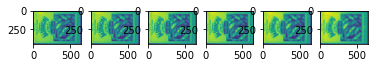

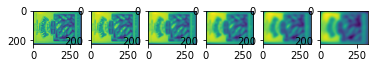

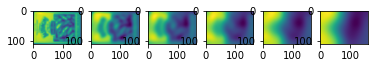

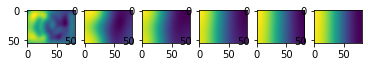

[[1.6, 2.015873679831797, 2.539841683149119, 3.2, 4.031747359663594, 5.079683366298239], [3.2, 4.031747359663594, 5.079683366298238, 6.4, 8.063494719327188, 10.159366732596478], [6.4, 8.063494719327188, 10.159366732596476, 12.8, 16.126989438654377, 20.318733465192956], [12.8, 16.126989438654377, 20.318733465192953, 25.6, 32.253978877308754, 40.63746693038591]]


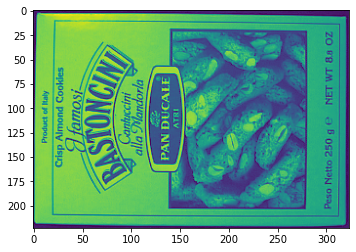

In [4]:
def ComputeNumOfOctaves(img):
    '''计算Octave组数 '''
    '''M/(2^O)>8   O<log2(M)-log2(8)'''
    '''最少为8'''
    height,width = img.shape[:2]
    return int(log2(min(height,width))-3)

# print(computeNumOfOctaves(img))

def GenerateGaussianImages(img):
    '''生成高斯金字塔并将金字塔中每组octave的每一层的标准差存储到sigmas中'''
    octaves_num = ComputeNumOfOctaves(img)
    num_of_layer=num_intervals + 3 
    img=BaseImage(img) #按照论文，一般相机拍出来的模糊程度是0.5，需要经过双线性插值放大后模糊程度变为1
    Gaussian_imgs=[]
    sigmas=[]
    
    for octaves_id in range(octaves_num):
        temp_imgs = []
        temp_sigmas=[]
        if octaves_id == 0 :
            base_img = GaussianBlur(img,GetSigma(1.6,1)) #按照论文，模糊程度从原来的1变为1.6。
        else:
#             print(octaves_id)
            base_img = Gaussian_imgs[octaves_id-1][num_intervals-1]#取上一组的第3张做下采样，当做下一组的第一层图像
            base_img = DownSampling(base_img)
        temp_imgs.append(base_img)
        K,temp_sigmas = ComputeGaussianKernal(1.6*(2**octaves_id),num_of_layer)
        pre_img=base_img
        for i in range(len(K)):
            processed_img = GaussianBlur(pre_img,K[i])
            temp_imgs.append(processed_img)
            pre_img = processed_img
        Gaussian_imgs.append(temp_imgs)
        sigmas.append(temp_sigmas)
        ShowPics(temp_imgs)#输出观察是否正常处理
    
    return Gaussian_imgs,sigmas

Gaussian_imgs,Gaussian_sigmas = GenerateGaussianImages(img)
print(Gaussian_sigmas)
plt.imshow(img)

D:\anacode3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


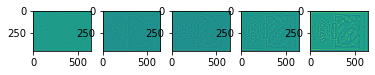

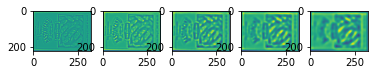

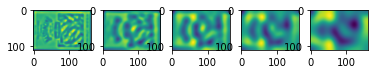

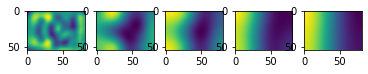

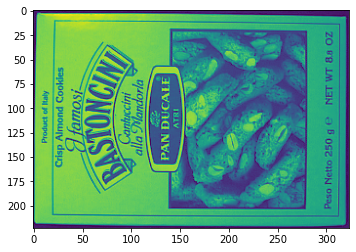

In [5]:
def GenerateDoGaussian(Gaussian_imgs,sigmas):
    '''构建高斯差分金字塔并返回每一曾的标准差'''
    Dog_imgs=[]
    Dog_sigmas=copy.deepcopy(sigmas)
    octaves_num , layers_num = np.array(Gaussian_imgs).shape
    for octave_id in range(octaves_num):
        temp_diff=[]
        for layer_id in range(layers_num-1):
            temp_diff.append(cv2.subtract(Gaussian_imgs[octave_id][layer_id],Gaussian_imgs[octave_id][layer_id+1]))
        Dog_imgs.append(temp_diff)
#         print(Dog_sigmas[octave_id])
        Dog_sigmas[octave_id].pop(0)
#         ShowPics(temp_diff)
#         print(0)
#         np.array(temp_diff)*50
#         print(1)
        ShowPics((np.array(temp_diff)))#速度非常慢
#     print(Dog_sigmas)

    return Dog_imgs,Dog_sigmas

Dog_imgs,Dog_sigmas=GenerateDoGaussian(Gaussian_imgs,Gaussian_sigmas)
# print(Dog_sigmas)

plt.imshow(img)

In [6]:
## 均匀网格插值 参考https://blog.csdn.net/weixin_48167570/article/details/123704075

def ComputeCentralGradient(pixel_cube):#[[last],[current],[next]]
    '''f'(x) = (f(x + 1) - f(x - 1)) / 2'''
    dx = (pixel_cube[1,2,1]-pixel_cube[1,0,1])*0.5
    dy = (pixel_cube[1,1,2]-pixel_cube[1,1,0])*0.5
    dt = (pixel_cube[0,1,1]-pixel_cube[2,1,1])*0.5
    return np.array([dx,dy,dt])

def ComputeCentralHessian(pixel_cube):
    '''f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)/1^2'''
    '''(d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4'''
    dxx = pixel_cube[1,2,1]-2*pixel_cube[1,1,1]+pixel_cube[1,0,1]
    dxy = (pixel_cube[1,2,2]-pixel_cube[1,2,0]-pixel_cube[1,0,2]+pixel_cube[1,0,0])/4
    dyy = pixel_cube[1,1,2]-2*pixel_cube[1,1,1]+pixel_cube[1,1,0]
    dyz = (pixel_cube[0,1,2]-pixel_cube[2,1,2]-pixel_cube[0,1,0]+pixel_cube[2,1,0])/4
    dzz = pixel_cube[0,1,1]-2*pixel_cube[1,1,1]+pixel_cube[2,1,1]
    dzx = (pixel_cube[0,2,1]-pixel_cube[0,0,1]-pixel_cube[2,2,1]+pixel_cube[2,0,1])/4
    return np.array([[dxx,dxy,dzx],[dxy,dyy,dyz],[dzx,dyz,dzz]])

def ComputeOffset(pixel_cube):
    '''计算偏移量'''
    Gradient = ComputeCentralGradient(pixel_cube)
    Hessian = ComputeCentralHessian(pixel_cube)
#     Offset = -np.dot(np.linalg.inv(Hessian),Gradient.T)
    Offset = np.linalg.lstsq(Hessian, Gradient.T)[0]
#当等式方程个数多于未知数时，使用最小二乘近似估计，
#在SIFT中方程个数等于未知数个数
    return Offset

D:\anacode3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


315
[[ 37.37753886 398.50706696   1.2124316    0.           2.53984168]
 [ 43.86588605 558.78379765   0.87441289   0.           2.53984168]
 [ 47.90049724 459.44772923   0.7128583    0.           2.53984168]
 ...
 [ 65.8067004   49.90000187   0.86538444   2.          10.15936673]
 [ 16.76417903  19.52083229   2.03961125   2.          12.8       ]
 [ 89.1415928   19.7449235    1.9300503    2.          12.8       ]]


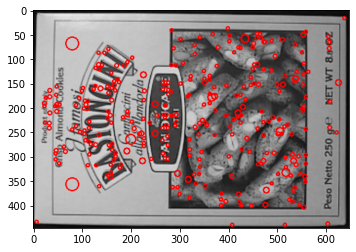

In [7]:
def DeleteRepeatedPoints(all_keypoints):
    '''删除重复元素'''
    all_keypoints=np.array(all_keypoints)
    idex =np.lexsort([all_keypoints[:,0]])    
    sorted_data = all_keypoints[idex,:]
    for i in range(len(sorted_data)-1):#没有重复的点
        if sorted_data[i][0]==sorted_data[i+1][0] and sorted_data[i][1]==sorted_data[i+1][1]:
            all_keypoints=np.delete(all_keypoints,idex[i],axis=0)
    return all_keypoints

def Contrast(pixel_cube):
    '''输入一个立方体判断该像素值是否是极值点'''
#     print(current_layer)
    return ((pixel_cube[1,1,1]<=pixel_cube[0,:,:]).all() \
            and (pixel_cube[1,1,1]<=pixel_cube[1,:,:]).all()\
            and (pixel_cube[1,1,1]<=pixel_cube[2,:,:]).all())\
            or ((pixel_cube[1,1,1]>=pixel_cube[0,:,:]).all() \
            and (pixel_cube[1,1,1]>=pixel_cube[1,:,:]).all()\
            and (pixel_cube[1,1,1]>=pixel_cube[2,:,:]).all())

def GetAllKeypoints(Dog_imgs,Dog_sigmas,Gaussian_imgs,origin_img):
    '''获取所有特征点'''
    '''取三层做判断，判断包括：0.与周围的立方体比较即非极大值抑制 1.阈值 2.极值点更新后5次内是否在格内 3.排除边缘上的点'''
    thresold= 0.5 * 0.04 / num_intervals *255  #超参数 用于舍去对比度较低的点
#     print(thresold)
    
    key_points=[]
    for octave_id in range(len(Dog_imgs)):
        octave_imgs = Dog_imgs[octave_id]
        for layer_id in range(1,len(octave_imgs)-1):
            last_layer = Dog_imgs[octave_id][layer_id-1]
            current_layer = Dog_imgs[octave_id][layer_id]
            next_layer = Dog_imgs[octave_id][layer_id+1]
            

#             print(np.array(current_layer).shape)
            height,width = np.array(current_layer).shape
            for i in  range(1,height-1):
                for j in range(1,width-1):
                    if abs(current_layer[i][j])<thresold: #舍弃低于阈值的点
                        continue
        #             print(current_layer[0:3,0:3])
                    
                    pixel_cube=np.array([last_layer[i-1:i+2,j-1:j+2],current_layer[i-1:i+2,j-1:j+2],next_layer[i-1:i+2,j-1:j+2]])
                    if Contrast(pixel_cube):#对比
                        offset = ComputeOffset(pixel_cube)#计算偏移量
    #                         print(pixel_cube)
    #                         print(offset)

                        #极值点位置更新
                        new_x = i
                        new_y = j 
                        new_z =layer_id

                        for times in range(5):
                            temp=[new_x,new_y,new_z]
                            new_x += round(offset[0])
                            new_y += round(offset[1])
                            new_z -= round(offset[2])
#                             print(times)
#                             print(offset)
                            if new_x-1<0 or new_x+1>=height or new_y-1<0 or new_y+1>=width or new_z-1<0 or new_z+1>=len(octave_imgs):
                                break
                            new_pixel_cube = np.array([octave_imgs[new_z-1][new_x-1:new_x+2,new_y-1:new_y+2],\
                                                           octave_imgs[new_z][new_x-1:new_x+2,new_y-1:new_y+2],\
                                                          octave_imgs[new_z+1][new_x-1:new_x+2,new_y-1:new_y+2]])
                            if abs(offset[0])>0.5 or abs(offset[1])>0.5 or abs(offset[2])>0.5 :
                                offset = ComputeOffset(new_pixel_cube)
                            else:
                                #边缘检测
                                central_value = octave_imgs[new_z][new_x,new_y]
                                central_gradient = ComputeCentralGradient(new_pixel_cube)
                                value_in_extremum = central_value + 0.5*np.dot(central_gradient,np.array([new_x,new_y,new_z]))
                                if abs(central_value)<thresold*2:
                                    break
                                Hessian = ComputeCentralHessian(new_pixel_cube)[:2,:2]
                                det = np.linalg.det(Hessian)
                                trace = Hessian.trace()
                                f = trace**2/det #有点类似CV课上讲的角点检测，区别是海森矩阵的构成以及f的函数式不同
                                if f > 12.1 : #论文中的经验值
                                    break
                                sigma= Dog_sigmas[octave_id][new_z]
#                                 key_points.append([new_x,new_y,new_z,sigma])
                                key_points.append([temp[0]+offset[0],temp[1]+offset[1],temp[2]+offset[2],octave_id,sigma])

                                break
#                         print()
    
    key_points=DeleteRepeatedPoints(key_points)

    circle_img=copy.deepcopy(origin_img)
    circle_img=BaseImage(circle_img)
    for i in range(len(key_points)):#查看目前提取特征效果
        cv2.circle(circle_img,(int(round(key_points[i][1])*(2**(key_points[i][3]))),int(round(key_points[i][0])*(2**(key_points[i][3])))),int(round(key_points[i][4])),(255,0,0),2)
    plt.imshow(circle_img)

    return key_points

all_keypoints=GetAllKeypoints(Dog_imgs,Dog_sigmas,Gaussian_imgs,origin_img)

circle_img=copy.deepcopy(origin_img)
circle_img=BaseImage(circle_img)

print(len(all_keypoints)) #展示特征点个数
print(all_keypoints)

# for i in range(len(all_keypoints)):#查看目前提取特征效果

#     cv2.circle(circle_img,(int(round(all_keypoints[i][1])*(2**(all_keypoints[i][3]))),int(round(all_keypoints[i][0])*(2**(all_keypoints[i][3])))),int(round(all_keypoints[i][4])),(255,0,0),2)
    
#     #cv2里坐标是反着设置的
# plt.imshow(circle_img)


In [11]:
def ComputeGradientValue(height,width,images):
    '''计算某个像素的近似梯度值'''
    return sqrt((images[height+1,width]-images[height-1,width])**2+(images[height,width+1]-images[height,width-1])**2)

def ComputeOrientation(height,width,images):
    '''计算梯度方向，y轴朝北，x轴朝东'''
    '''atan2(y,x)'''
    angle = atan2(images[height+1,width]-images[height-1,width],images[height,width-1]-images[height,width+1])
    
    angle = (angle*360)/(2*pi)
    if angle<0:
        angle=angle+360
    return int(angle)
    
def ComputeKeypointsOritentations(Gaussian_imgs,key_points,Gaussian_sigmas):
    '''取特征点3*1.5σ半径内的领域的所有点计算梯度和方向，对所有梯度进行高斯平滑，分36bin选定主角度和辅角度'''
    ratio_array=[]
    
    keypoints_info = []
    for keypoint in key_points:
        angle_array=[]
        octave_id = int(keypoint[3])
        height = int(round(keypoint[0]))
        width = int(round(keypoint[1]))
        layer_id = int(round(keypoint[2])+1)
        images = Gaussian_imgs[octave_id][layer_id]
        sigma = Gaussian_sigmas[octave_id][layer_id]
        gaussian_constant=-0.5/sigma**2
        gaussian_sigma = 1.5*sigma
#         radius = int(round(gaussian_sigma)*3)
        radius = int(round(gaussian_sigma))
        
        max_height,max_width = np.array(images).shape
        raw_bins=np.zeros(36)
        smooth_bins = np.zeros(36)
        
        for i in range(-radius,radius+1):
            if height-i>=0 and height+i<=max_height-1:
                for j in range(-radius,radius+1):
                    if width-j>=0 and width<=max_width-1:
                        weight = exp(gaussian_constant*(i**2+j**2))
#                         print(weight)
                        if height+i-1<0 or height+i+1>=max_height-1 or width+j-1<0 or width+j+1>=max_width:
                            #梯度计算顺利进行
                            continue
            
                        gradient = ComputeGradientValue(height+i,width+j,images)
                #         print(gradient)
                        orientation = ComputeOrientation(height+i,width+j,images)
                        bins_index = int(orientation/10)
                        raw_bins[bins_index] += weight*gradient
                        
#         print(raw_bins)
        
        #高斯平滑直方图
        #参考帕斯卡三角快速获得高斯核权重1 4 6 4 1 
        #原理参考网站 https://theailearner.com/2019/05/06/gaussian-blurring/
        for bins_index in range(len(smooth_bins)):
            smooth_bins[bins_index] = 6*raw_bins[bins_index]+4*(raw_bins[bins_index-1]+raw_bins[(bins_index+1)%36])+raw_bins[bins_index-2]+raw_bins[(bins_index+2)%36]
        
        max_value = max(smooth_bins)
        
#         times=0
        for bins_index in range(len(smooth_bins)):
            
            if smooth_bins[bins_index]>=0.8*max_value and smooth_bins[bins_index]>=smooth_bins[bins_index-1] and smooth_bins[bins_index]>=smooth_bins[(bins_index+1)%36]:
                #利用二次插值求得峰值具体位置
                #参考网站 https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
                peak = 0.5*(smooth_bins[bins_index-1]-smooth_bins[(bins_index+1)%36])/(smooth_bins[bins_index-1]-2*smooth_bins[bins_index]+smooth_bins[(bins_index+1)%36])*10+bins_index*10+5
                peak=peak%360
                new_keypoint=np.append(keypoint,[peak])
                keypoints_info.append(new_keypoint)
#                 print(times)
#                 times+=1
#         ratio_array.append(times)
#     print(ratio_array)
    print('特征点总个数{}'.format(len(keypoints_info)))
    return keypoints_info
    
keypoints_info=ComputeKeypointsOritentations(Gaussian_imgs,all_keypoints,Gaussian_sigmas)


# print(keypoints_info)


特征点总个数374


In [12]:
#keypoints_info=[x,y,layer_id,octave_id,simga,orientation]
# print(keypoints_info)

def ComputeDescriptor(Gaussian_imgs, keypoint_info, blocks_num=4, bins_num=8,float_tolerance = 1e-7):
    '''计算单个特征点的描述子'''
    '''默认使用3σ原则 即取3σ领域内的点计算梯度并施加高斯平滑'''

    key_row = keypoint_info[0]
    key_col = keypoint_info[1]
    layer_id = int(round(keypoint_info[2]) + 1)
    octave_id = int(keypoint_info[3])
    sigma = keypoint_info[4]
    key_orientation = keypoint_info[5]
    # x轴朝东 y轴朝北
    raw_cube = np.zeros((blocks_num + 2, blocks_num + 2, bins_num))
    # +2是为了防止插值出界
    images = Gaussian_imgs[octave_id][layer_id]
    max_height, max_width = np.array(images).shape
    weight_multiplier = -0.5 / ((0.5 * blocks_num) ** 2)
    
    block_width = 3 * sigma / 2
#     print(block_width)
    window_radius = int(round(sqrt(2) * block_width * (blocks_num + 1))*0.5)
    '''划定一个比区域稍大的范围选点，使得确保所有目标点在该范围内，依次遍历判断是否在目标区域内'''
    window_radius = min(window_radius, int(sqrt(max_width ** 2 + max_height ** 2)))
    
#     print(sigma,window_radius)
#     origin_img=cv2.imread('test4.png')
#     circle_img=copy.deepcopy(origin_img)
#     circle_img=BaseImage(circle_img)
#     cv2.circle(circle_img,(int(round(key_col)*(2**(octave_id))),int(round(key_row)*(2**(octave_id)))),int(round(window_radius)),(255,0,0),2)
#     plt.imshow(circle_img)
#     plt.show()

    raw_info = []
    for row_delta in range(-window_radius, window_radius + 1):
        for col_delta in range(-window_radius, window_radius + 1):
            img_row = int(round(key_row + row_delta))
            img_col = int(round(key_col + col_delta))
            img_row_delta = img_row - key_row
            img_col_delta = img_col - key_col

            angle = (key_orientation / 180 * pi - atan2(img_row_delta, img_col_delta)) % (2 * pi)
            #             print(angle)
            projected_row = sin(angle) * sqrt(img_row_delta ** 2 + img_col_delta ** 2)
            projected_col = cos(angle) * sqrt(img_row_delta ** 2 + img_col_delta ** 2)
            block_row = projected_row / block_width
            block_col = projected_col / block_width

            if block_row + 2 > -1 and block_row + 2 < blocks_num and block_col + 2 > -1 and block_col + 2 < blocks_num:
                # print(block_row, block_col)
                if img_row-1<0 or img_row+1>=max_height-1 or img_col-1<0 or img_col+1>=max_width:
                            #梯度计算顺利进行
                    continue
                point_gradient=ComputeGradientValue(img_row,img_col,images)
                point_orientation=ComputeOrientation(img_row,img_col, images)
                orientation_bin = point_orientation*8/360
                point_value=exp(weight_multiplier*(block_row**2+block_col**2))*point_gradient
#                 print(exp(weight_multiplier*(block_row**2+block_col**2)),row_delta,col_delta)
                raw_info.append([block_row,block_col,orientation_bin,point_value])

    #以下为三次插值部分，插值加入到raw_cube中
    for block_row,block_col,orientation_bin,point_value in raw_info:
        #用int还是floor 表现在负数上会不同
        lower_row = int(floor(block_row))
        lower_col = int(floor(block_col))
        lower_ori = int(floor(orientation_bin))
#         print(lower_row,lower_col,lower_ori)
        row_ratio= block_row - lower_row
        col_ratio = block_col - lower_col
        orientation_ratio = orientation_bin - lower_ori

        #使用三次插值
        c0 = point_value*row_ratio
        c1 = point_value*(1-row_ratio)
        c00 = c0*(1-orientation_ratio)
        c01 = c0*orientation_ratio
        c10 = c1*(1-orientation_ratio)
        c11 = c1*orientation_ratio
        c100 = c00*(1-col_ratio)
        c110 = c00*col_ratio
        c101 = c01*(1-col_ratio)
        c111 = c01*col_ratio
        c000 = c10*(1-col_ratio)
        c010 = c10*col_ratio
        c001 = c11*(1-col_ratio)
        c011 = c11*col_ratio
        
#         print([c000,c010,c100,c110,c001,c011,c101,c111])
        raw_cube[lower_row+3][lower_col+3][lower_ori%bins_num]+=c000
        raw_cube[lower_row+3][lower_col+4][lower_ori%bins_num]+=c010
        raw_cube[lower_row+4][lower_col+3][lower_ori%bins_num]+=c100
        raw_cube[lower_row+4][lower_col+4][lower_ori%bins_num]+=c110
        raw_cube[lower_row+3][lower_col+3][(lower_ori+1)%bins_num]+=c001
        raw_cube[lower_row+3][lower_col+4][(lower_ori+1)%bins_num]+=c011
        raw_cube[lower_row+4][lower_col+3][(lower_ori+1)%bins_num]+=c101
        raw_cube[lower_row+4][lower_col+4][(lower_ori+1)%bins_num]+=c111

    descriptor_vector = raw_cube[1:-1][1:-1][:].flatten()
#     print(descriptor_vector)
    norm=np.linalg.norm(descriptor_vector)
    threshold = 0.2*norm
#     print(threshold)
    descriptor_vector[descriptor_vector>threshold]=threshold
    descriptor_vector/=max(np.linalg.norm(descriptor_vector),float_tolerance)
    
    
#     print(descriptor_vector)
    coordinate = [int(round(key_col)*(2**octave_id)),int(round(key_row)*(2**octave_id))]
#     print(descriptor_vector)
    
    

    return descriptor_vector,coordinate
                
    
def ComputeAllDescriptors(Gaussian_imgs, keypoints_info):
    descriptors=[]
    coordinates=[]
#     times=0
    for keypoint_info in keypoints_info:
        descriptor_vector,coordinate=ComputeDescriptor(Gaussian_imgs, keypoint_info)
        descriptors.append(descriptor_vector)
        coordinates.append(coordinate)
#         times+=1
#         print(times)
        
    return np.array(descriptors),np.array(coordinates)
        
# descriptor_vector,coordinate = ComputeDescriptor(Gaussian_imgs, keypoints_info[0])
descriptors,coordinates=ComputeAllDescriptors(Gaussian_imgs, keypoints_info)

In [13]:
def ComputeCosineSimilarity(vector1,vector2):
    return np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
def ComputeL2(vector1,vector2):
    return np.linalg.norm(vector1-vector2)
def MatchKeypoints(descriptors1,descriptors2,threshold=0.5):
    '''两张图片的关键点的特征向量根据余弦相似度用暴力搜索做匹配'''
    '''由于时间关系不再使用RANSAC方法，感兴趣的可以通过网址学习opencv的最近邻搜索加速和RANSAC方法提高精度做匹配'''
    good_matching=[]
    for i in range(len(descriptors1)):
        vector1 = descriptors1[i]
        temp_index = 0
        min_value = 128
        for j in range(len(descriptors2)):
            vector2 =descriptors2[j]
#             cos_similarity=ComputeCosineSimilarity(vector1,vector2)
            cos_similarity=ComputeL2(vector1,vector2)
#             print(cos_similarity)
            
            if cos_similarity<min_value:
                temp_index = j
                min_value = cos_similarity
#         print(i,min_value,temp_index)
        if min_value<threshold:
            good_matching.append([i,temp_index])
#         print()
    print(len(good_matching))
    return good_matching

good_matching=MatchKeypoints(descriptors1,descriptors2)


NameError: name 'descriptors1' is not defined

正在生成高斯金字塔


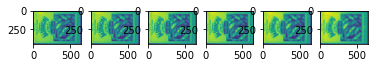

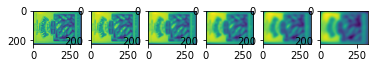

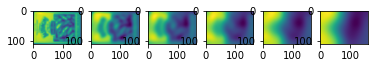

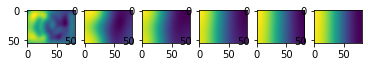

正在生成高斯差分金字塔


D:\anacode3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


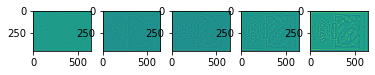

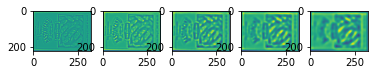

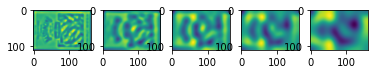

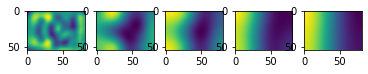

正在寻找特征点


D:\anacode3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


正在获取特征点方向
特征点总个数374
正在计算所有特征点的描述子
正在生成高斯金字塔


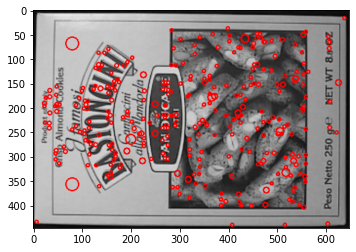

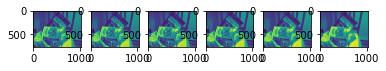

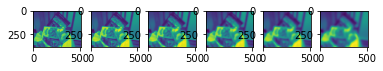

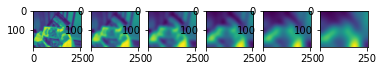

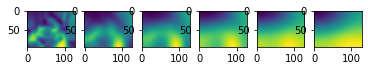

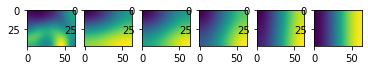

正在生成高斯差分金字塔


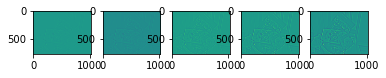

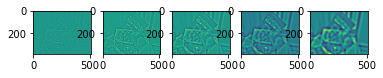

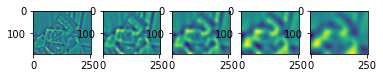

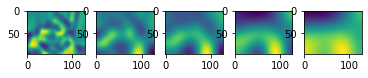

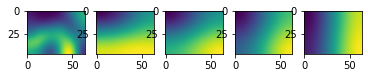

正在寻找特征点
正在获取特征点方向
特征点总个数542
正在计算所有特征点的描述子


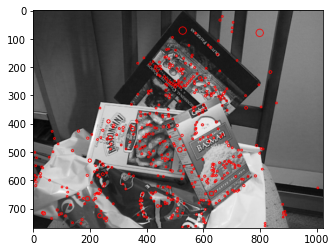

In [14]:
def GetAllDescriptors(img_location):
    img = cv2.imread(img_location,0)
    origin_img = cv2.imread(img_location)
    img=img.astype('float32')
    print('正在生成高斯金字塔')
    Gaussian_imgs,Gaussian_sigmas=GenerateGaussianImages(img)
    print('正在生成高斯差分金字塔')
    Dog_imgs, Dog_sigmas=GenerateDoGaussian(Gaussian_imgs,Gaussian_sigmas)
    print('正在寻找特征点')
    all_keypoints=GetAllKeypoints(Dog_imgs,Dog_sigmas,Gaussian_imgs,origin_img)
    print('正在获取特征点方向')
    keypoints_info = ComputeKeypointsOritentations(Gaussian_imgs, all_keypoints, Gaussian_sigmas)
    print('正在计算所有特征点的描述子')
    descriptors, coordinates = ComputeAllDescriptors(Gaussian_imgs, keypoints_info)
    base_img = cv2.imread(img_location)
    show_img = BaseImage(base_img)

    return descriptors, coordinates,show_img
descriptors1,coordinate1,img1=GetAllDescriptors('test4.png')
descriptors2,coordinate2,img2=GetAllDescriptors('match.png')

69


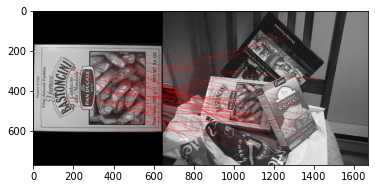

In [16]:
def MatchPictures(descriptors1,descriptors2,coordinate1,coordinate2,img1,img2):
    good_matching=MatchKeypoints(descriptors1,descriptors2)
    h1, w1,_ = img1.shape
    h2, w2,_ = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)
    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1[:,:,i]
        newimg[:h2, w1:w1 + w2, i] = img2[:,:,i]
    for img1_index,img2_index in good_matching:
    #     print(coordinate2[img2_index])
        pt1=(coordinate1[img1_index][0],coordinate1[img1_index][1]+hdif)
        pt2=(coordinate2[img2_index][0]+w1,coordinate2[img2_index][1])
        cv2.line(newimg, pt1, pt2, (255, 0, 0))
    #     print(pt1,pt2)

    plt.imshow(newimg)
    plt.show()

MatchPictures(descriptors1,descriptors2,coordinate1,coordinate2,img1,img2)

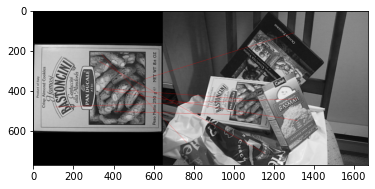

In [17]:
def MatchPicturesWithcv(descriptors1,descriptors2,coordinate1,coordinate2,img1,img2):
    MIN_MATCH_COUNT = 10
    # Initialize and use FLANN
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1.astype(np.float32), descriptors2.astype(np.float32), k=2)
    # Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    h1, w1,_ = img1.shape
    h2, w2,_ = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)
    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1[:,:,i]
        newimg[:h2, w1:w1 + w2, i] = img2[:,:,i]

    temp=copy.deepcopy(newimg)

    for m in good:
    #     print(coordinate2[img2_index])
        pt1=(coordinate1[m.queryIdx][0],coordinate1[m.queryIdx][1]+hdif)
        pt2=(coordinate2[m.trainIdx][0]+w1,coordinate2[m.trainIdx][1])
        cv2.line(newimg, pt1, pt2, (255, 0, 0))

    #     print(pt1,pt2)

    plt.imshow(newimg)
    plt.show()
MatchPicturesWithcv(descriptors1,descriptors2,coordinate1,coordinate2,img1,img2)